# AI 4 Materials Industry
# Case study 1: Faulty steel plates
# Notebook 2: Random forests for tabular data


## Building a predictive model

The next step is to start building models that can classify the steel plates. We will start with a random forest model, which is one of the most basic and robust machine learning methods for small to medium datasets. Its robustness stems from two core properties. First of all they are built on decision trees, where the data is sequentially split at specific values of different properties. In contrast to for instance a linear model, no specific assumptions are made with respect to the function that relates the input data with the output classes making it well-suited for non-linear data. Secondly, a random forest is an ensemble of decision trees, combining many weak learners to create one strong learner. As a result uncorrelated errors will automatically get averaged out. First, we must set up our environment again.



In [1]:
# ! pip install graphviz
# ! pip install memory_profiler

In [2]:
%reload_ext autoreload
%load_ext memory_profiler

%autoreload 2
%matplotlib inline

import numpy as np # Math functions
import pandas as pd # Pandas is used for handling databases, and will be used for reading and manipulating the data
import matplotlib.pyplot as plt # Plot functions
import seaborn as sns # More plot functions

sns.set_palette('colorblind') # Making the plots colorblind-friendly
sns.set_style('darkgrid') # More info at https://seaborn.pydata.org/tutorial/aesthetics.html

### Creating a train, validation and test set

The first step in any machine learning study is splitting the data into different parts, to be used at different parts of the model creation:
* **Training set**: A dataset to be used to train the data on. As a result, the model can easily overfit on this data and it is important to verify performance on independent datasets to verify generalization.
* **Validation set**: Dataset the model will not be trained on. This dataset is evaluated at the end of the training procedure to test the generalization performance of the model. 
* **Test set**: The more the model is retrained, the more contaminated the validation dataset can become as humans are inclined to adapt their hyperparameters to get better validation performance. To remedy this, a final hold-out or test dataset is kept to do one final examination before pushing the model to production. New data can of course also be used.

To ensure that the training, validation and test scores are correlated the distributions within the dataset should be similar. A random sample can be sufficient for a large dataset, but often it is good to take explicit measures to ensure this (or at least verify).

Some techniques:
* **Shuffle the data**: Ensures there's no ordering which is conserved (for instance all data of one class is listed first).
* **Stratification**: ensuring the distributions of specific variables, definitely the target variables are consistent. This also ensures each of the datasets contains at least one sample of each class. If this were not the case it's possible certain classes would be completely unknown to the model, making it impossible to classify them.
* **EDA**: verify conclusions made in the exploratory data analysis remain consistent in all sets.
* **Testing**: Best is of course explicitly testing whether your datasets behave similar. Rather than trying to create the best model, it can be good in this case to create different models in complexity and even method and see if the datasets perform the same.

Another choice to make is how big the train, validation and test sets. Here, we will take a standard split of 80/10/10. Most important is to feed the model as much data as possible, while still having a representative validation and test set. Larger datasets can have relatively smaller val/test sets, smaller datasets may need larger or in the case of random forests, no validation set.

To make the notebook reproduceable we will fix the random seed for all functions.

First let's recover our dataframe.


In [3]:
df = pd.read_feather('vsc-ai4mi-case1-eda.feather')

In [4]:
# sklearn is scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
# This is a helper function which allows us to split the data set into a training and validation or test set.

seed = 1337 # Fixing the random seed makes the notebook exactly reproducible

allcolumns = df.columns
print(df.columns)
# These columns are the features that the model will use as "known" data.
inp = ['X_Center', 'X_Size', 'Y_Center', 'Y_Size', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas']
# These are the classes that the model will attempt to classify.
target = ['Pastry', 'Z_Scratch', 'K_Scratch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults']

# First split splits off 80% of the data into the training set
train, test = train_test_split(df, test_size=0.2, random_state=seed, shuffle=True, stratify=df[target])

# Second split splits the remaining 20% into two equal sized validation and test set.
val, test = train_test_split(test, test_size=0.5, random_state=seed, shuffle=True, stratify=test[target])

# We have used stratify to ensure a similar distribution of classes in each set,
# otherwise we risk under- or overrepresenting small classes in our validation or
# test set, which will throw off our metrics.

Index(['Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scratch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'X_Size', 'Y_Size', 'X_Center',
       'Y_Center'],
      dtype='object')


A simple trick to calculate the distribution of classes using one-hot encoding is to calculate the mean: since the values are either 1 or 0, the mean will give you the percentage of occurence for each class. This way we can compare the distribution of classes between the training, validation and test set.

In [5]:
train[target].mean()

Pastry          0.081186
Z_Scratch       0.097938
K_Scratch       0.201675
Stains          0.037371
Dirtiness       0.028351
Bumps           0.206830
Other_Faults    0.346649
dtype: float64

### Exercise 1

* Calculate the mean of the target classes in the validation and test set.
* Compare to see if the distribution roughly the same in all three sets.
* Is there a class for which this is not the case? Why?

### Solution

We see that the mean of each class is very similar, indicating a similar distribution of the classes. The Dirtiness class differs slightly, because it is so small.

## Building a predictive model: Decision tree

The next step is to train a model to classify new samples. We will start with the simplest way to do this: a decision tree. We'll train a single decision tree to classify K_Scratches using just default parameters. Here we also see the standard structure of how these models tend to work. You create an instance of a model, train it by feeding it data, then check it by looking at some metric.


### A note about metrics

"How well does the model perform its task?" is not a very well-defined question. How do you measure its performance? There are many different metrics, each with advantages and disadvantages, and which metric is applicable depends on the problem at hand. For now we'll use the **accuracy**, which is commonly used as a default metric. The accuracy is defined as the percentage of times the model makes a correct prediction. We'll come back to how the prevalence of different classes can distort this metric, and discuss other metrics. For now, the accuracy works well enough to get a feel for how we train a model.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create the tree
K_tree = DecisionTreeClassifier()
# Train the tree
K_tree.fit(train[inp], train["K_Scratch"])
# Validate the tree
print("Accuracy:", accuracy_score(y_true=val["K_Scratch"], y_pred=K_tree.predict(val[inp]), normalize=True))

Accuracy: 0.9639175257731959


We're already getting a rather good accuracy with a single decision tree with standard hyperparameters, which shows how robust this architecture really is. We can also plot this tree, but as it is now it's too complex to visualize easily. Let's train a shallower tree so we can inspect it and see what's going on.

Accuracy: 0.9536082474226805


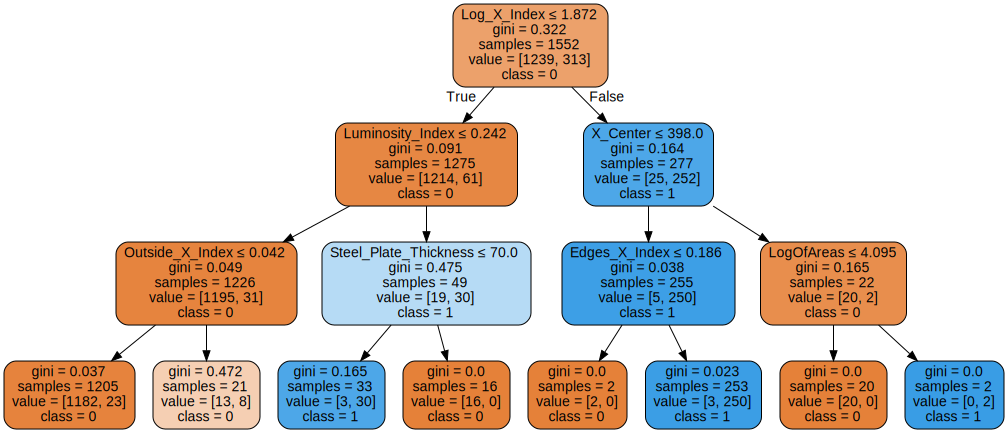

In [7]:
# These packages make the visualization easier to digest
import graphviz
from sklearn.tree import export_graphviz

# Create a shallow tree of only 3 layers
shallow_tree = DecisionTreeClassifier(max_depth=3)
shallow_tree.fit(train[inp], train["K_Scratch"])
print("Accuracy:", accuracy_score(y_true=val["K_Scratch"], y_pred=shallow_tree.predict(val[inp]), normalize=True))

# Plot the tree
dot_data = export_graphviz(shallow_tree, out_file=None, 
                     feature_names=inp,  
                     class_names=["0", "1"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph

First off: note that even with just a single decision tree with just 3 layers, we're already hitting an accuracy of around 96% on our validation set!

So how should we understand this decision tree?

The tree will make a decision at every layer, based on a single variable. It will separate the dataset based on whether the data falls below or above a certain threshold in the chosen variable.

At every node, the tree will try to minimize its so-called _gini_ or _impurity_ score, meaning it will try to split the dataset as efficiently as possible on a single feature so most instances of K_Scratches will fall on one side, and most instances of "not a K_Scratch" will fall on the other. The gini score varies from 0 for a perfectly separated set of one class only, to 0.5 for an equal mix of classes. 

![Gini](Gini.png)

You can see that by splitting on the X_Size of the defect, it has 61 K_Scratches for 1214 not-K_Scratches on one side, with 252 vs 25 on the other. Then the tree goes down and tries to filter out as many stragglers as possible at every layer. As you can see, if a node has a mixture of both classes the gini score is high, if it contains only one type, the gini score is 0.

The way a decision tree then actually decides on a category is simple: it arrives at a leaf node (the bottom row) and outputs the majority class. For slightly more granular information, it's also possible to have it output the percentage of how much the class makes up the total leaf. This is commonly interpreted as a sort of "confidence" the tree has in the category it has chosen, but be wary that this interpretation is not entirely correct.

### Exercise 2:

* Train a decision tree for a class of your choice and plot it by copy/pasting the cell above.
* How does it differ?
* What is the accuracy?

### Solution

Bumps seem to be more dependent on processing information such as the type of steel plate, its size and thickness, rather than image information. The accuracy seems lower however, likely because this is a more difficult defect to detect.

## Building a predictive model: Random forest

Now let us combine many decision trees in a random forest. We will start with a completely default random forest. Even in this case we still have to make one important choice. We made a tacit decision earlier to create a simple model for each defect, rather than one more complex model that will immediately try to pick which class it is. In the first case the classification task is simpler, as the model will simply go for true/false for each class. In the second case we are including more information, which could make it more robust. We'll stick to one model per class for now and come back to this later.

An important note should be made about the validation set for random forests. The random forest uses an ensemble of decision trees, each of which is trained using bootstrapping (each tree sees only part of the full dataset). The standard implementation sees only 63.2% of the data. As a result, each decision tree can be tested on the remaining 36.8% of the data, resulting in what is called the Out-Of-Bag (OOB) score. Especially when there is little data available it can be sufficient to use the OOB score. The OOB score is typically a bit lower than the validation score as fewer trees are combined per data point. It is also an option to first judge the OOB score during initial hyperparameter tuning to add further protection against contamination of the validation set.

To access the OOB score we need to explicitly enable it. To avoid warnings we also set n_estimators, the number of trees in the ensemble to 100.


In [8]:
# RandomForestClassifier is an ensemble of decision trees which collectively decide on how to classify a sample.
from sklearn.ensemble import RandomForestClassifier

# We will train a random forest on the K_Scratch fault again
K_rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=seed)
K_rf.fit(train[inp], train["K_Scratch"])
print('Train:', K_rf.score(train[inp], train["K_Scratch"]))
print('OOB:', K_rf.oob_score_)
print('Val: ', K_rf.score(val[inp], val["K_Scratch"]))

Train: 1.0
OOB: 0.9819587628865979
Val:  0.979381443298969


We see that we get a reasonable fit with default settings, and the the OOB score is indeed a fairly good predictor of what the validation score will be.

### Exercise 3

* Train a random forest on the class you chose in exercise 2.
* How does the accuracy compare to a single tree?
* How does the OOB score compare to the validation accuracy?

### Solution

We will now train a random forest for each of the defect classes and see how they perform. Can you spot any troublemakers?

      target    set     score
0     Pastry  train  1.000000
1     Pastry    val  0.943299
2     Pastry    oob  0.938144
3  Z_Scratch  train  1.000000
4  Z_Scratch    val  0.979381


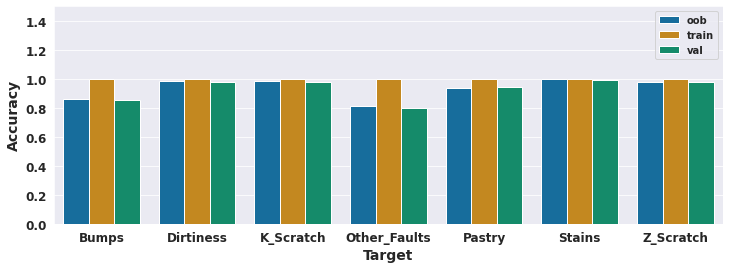

In [9]:
def plot_trainvaloob(tempdf):
    tempdf[['target','set']] = tempdf[['target','set']].astype('category')
    sns.barplot(data=tempdf, hue="set", x="target", y ="score", ax = ax)
    ax.set_ylim(0,1.5)
    ax.set_ylabel('Accuracy', weight='bold', fontsize=14)
    ax.set_xlabel('Target', weight='bold', fontsize=14)
    plt.xticks(fontsize=12, weight=800)
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12, prop={'weight': 800})

# Answer
tempdf = pd.DataFrame(columns=['target', 'set', 'score'])
tempdict = {"target": [], "set": [], "score": []}
fig, ax = plt.subplots(1,1, figsize=(12,4))

for i in range(len(target)):
    t = target[i]
    #print(t)
    rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=seed)
    rf.fit(train[inp], train[t])
    
    tempdict["target"].append(t)
    tempdict["set"].append("train")
    tempdict["score"].append(rf.score(train[inp], train[t]))
    
    tempdict["target"].append(t)
    tempdict["set"].append("val")
    tempdict["score"].append(rf.score(val[inp], val[t]))
    
    tempdict["target"].append(t)
    tempdict["set"].append("oob")
    tempdict["score"].append(rf.oob_score_)
    
tempdf = pd.DataFrame(tempdict)

print(tempdf.head())
plot_trainvaloob(tempdf)


## Number of trees (n_estimators)

The first important parameter is number of trees. More trees equals better performance, but make your code run slower. 
Depending on how much data you have it may be worthwhile testing your other hyperparameters with less trees, then later making a final model with a higher number of trees. For very large datasets it can also be worth showing each tree less data than the standard bootstrap sample of 63.2% (100% with repetition). Due to the limited size of our dataset here we will not further investigate this.

Let us look at the Bumps model and see how it evolves with number of estimators.


We will now explore different model parameters to see if we can get better validation performance. To do this we will tune the so-called hyperparameters of the model. Hyperparameters, because they are the settings that tell the model how it should optimize its internal parameters when fitting to the data.

We'll focus on bumps and ignore the other defects for now.

In [10]:
t = 'Bumps'
n_est = [20,50,100,250,500,1000,2500]

train_score = []
oob_score = []
val_score = []
for n in n_est:
    rf = RandomForestClassifier(n_estimators=n, min_samples_leaf=1, max_features=0.67, oob_score=True, random_state=seed)
    %time %memit rf.fit(train[inp], train[t])
    train_score.append(rf.score(train[inp], train[t]))
    oob_score.append(rf.oob_score_)
    val_score.append(rf.score(val[inp], val[t]))
    print(n, " trees, validation score: ", val_score[-1])
    print()
    

peak memory: 311.01 MiB, increment: 0.41 MiB
CPU times: user 232 ms, sys: 16.5 ms, total: 248 ms
Wall time: 428 ms
20  trees, validation score:  0.845360824742268

peak memory: 311.07 MiB, increment: 0.00 MiB
CPU times: user 488 ms, sys: 18.1 ms, total: 506 ms
Wall time: 622 ms
50  trees, validation score:  0.845360824742268

peak memory: 311.08 MiB, increment: 0.01 MiB
CPU times: user 897 ms, sys: 17.1 ms, total: 914 ms
Wall time: 1.03 s
100  trees, validation score:  0.8505154639175257

peak memory: 309.47 MiB, increment: -1.62 MiB
CPU times: user 2.15 s, sys: 16.9 ms, total: 2.17 s
Wall time: 2.29 s
250  trees, validation score:  0.8556701030927835

peak memory: 312.03 MiB, increment: 2.38 MiB
CPU times: user 4.25 s, sys: 18.4 ms, total: 4.26 s
Wall time: 4.39 s
500  trees, validation score:  0.8608247422680413

peak memory: 314.44 MiB, increment: 7.48 MiB
CPU times: user 8.44 s, sys: 35.9 ms, total: 8.48 s
Wall time: 8.82 s
1000  trees, validation score:  0.865979381443299

peak me

CPU time clearly increases linearly with trees, memory usage remains the same due to our small dataset.

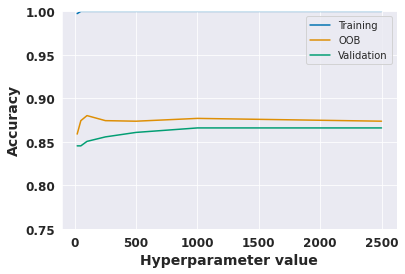

In [11]:
# Plotting the results from the previous cell.

from functions import plot_train_oob_val

plot_train_oob_val(n_est, train_score, oob_score, val_score)

We see that the effect of more estimators is very limited. We can stick to 100 and use more for the final models.

Other interesting hyperparameters include:


### Leaf samples
The random forest can perfectly fit the data because it can choose to split it down to the single datapoint level, which can cause overfitting.

The parameter `min_samples_leaf` lets us define how many samples there should minimally be at the end of the tree. We would expect this to lower the training score, as the model won't be able to fit perfectly anymore, but that can help it generalize better, raising the validation score.

### Number of features
Each time the data is split, the random forest only looks at a random subsample of the columns. Reducing this can increase the variance of the trees and reduce overfitting. Raising it exposes more data at each split. The default is 63%. A fractional input is a percentage of the total number of features, an integer is the absolute number.

### Exercise 4: Hyperparameter tuning

Loop over different hyperparameters `min_samples_leaf` and `max_features` of the random forest model (you can copy/paste the code from above). 

Optional: How does the performance of the model scale as a function of the number of trees? Also have a look at the compute time as your hyperparameters change using jupyter's [profiling tools %time and %memit](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html).

(Note: The compute time scales linearly with the number of trees.)

### Solution

peak memory: 348.26 MiB, increment: 0.25 MiB
CPU times: user 281 ms, sys: 18.7 ms, total: 300 ms
Wall time: 776 ms
2  features, validation score:  0.8556701030927835

peak memory: 348.30 MiB, increment: 0.00 MiB
CPU times: user 314 ms, sys: 10.9 ms, total: 325 ms
Wall time: 435 ms
3  features, validation score:  0.8711340206185567

peak memory: 348.30 MiB, increment: 0.00 MiB
CPU times: user 377 ms, sys: 16.9 ms, total: 394 ms
Wall time: 505 ms
5  features, validation score:  0.8556701030927835

peak memory: 348.30 MiB, increment: 0.00 MiB
CPU times: user 557 ms, sys: 12.9 ms, total: 570 ms
Wall time: 682 ms
10  features, validation score:  0.8556701030927835

peak memory: 348.30 MiB, increment: 0.00 MiB
CPU times: user 619 ms, sys: 16.9 ms, total: 636 ms
Wall time: 748 ms
12  features, validation score:  0.8505154639175257

peak memory: 348.30 MiB, increment: 0.00 MiB
CPU times: user 739 ms, sys: 11.3 ms, total: 750 ms
Wall time: 862 ms
15  features, validation score:  0.8556701030927

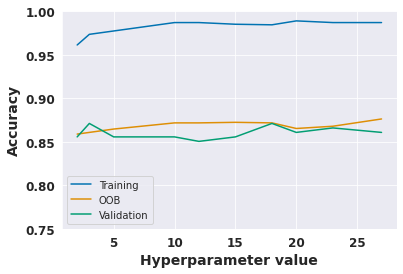

In [12]:
from functions import plot_train_oob_val

t = 'Bumps'
features = [2, 3, 5, 10, 12, 15, 18, 20, 23, 27]

train_score = []
oob_score = []
val_score = []
for f in features:
    rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=f, oob_score=True, random_state=seed)
    %time %memit rf.fit(train[inp], train[t])
    train_score.append(rf.score(train[inp], train[t]))
    oob_score.append(rf.oob_score_)
    val_score.append(rf.score(val[inp], val[t]))
    print(f, " features, validation score: ", val_score[-1])
    print()

plot_train_oob_val(features, train_score, oob_score, val_score)

By extremely precise tuning of the hyperparameters, we can push the validation score a little bit higher than would otherwise be possible, but that would just overfit the model to the validation set. This is why it's important to keep a separate test set.

### Exercise 5

Create a random forest model for the `Other_Faults` class and tune the hyperparameters.
* What accuracy do you get? 
* Does the model generalize well? 
* Was there a speed tradeoff to make?
* Give the model a distinct name, as we'll use it again later! 

## Solution:

## Support, metrics and confusion

Let's train a random forest model on all classes together and see what happens.

In [13]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=seed)
rf.fit(train[inp], train[target])
print('Train:',rf.score(train[inp], train[target]))
print('OOB:',rf.oob_score_)
print('Val:',rf.score(val[inp], val[target]))

Train: 1.0
OOB: 0.6868556701030928
Val: 0.6649484536082474


While the train and OOB scores are good, the model clearly struggles on the validation set. One common reason for this when using multiple classes at once is a so-called class imbalance. When one class is more common than the others, the minority classes are quickly lost. Sometimes the model may simply predict that all data points belong to the majority class.

In [14]:
train[target].sum()

Pastry          126
Z_Scratch       152
K_Scratch       313
Stains           58
Dirtiness        44
Bumps           321
Other_Faults    538
dtype: int64

Indeed this suggests it may be more favorable to focus on the difficult but large class Other_Faults or on classes like Bumps and K_Scratch. Trying to predict Dirtiness may simply not be worth it. Let's try to take this class imbalance into account. This is where it becomes important to look more closely at the metrics we're using and what they really say.

## Confusion Matrix

The confusion matrix is a very important tool to understand how often a model classifies and misclassifies things.

It shows four values:
* True positives (TP) (the class is present and the model detects it)
* True negatives (TN) (the class is not present and the model detects nothing)
* False positives (FP) (the class is not present but the model thinks it is)
* False negatives (FN) (the class is present but the model does not detect it)

In these examples, the confusion matrix is output as:

[TN, FP]

[FN, TP]


[[178   0]
 [ 10   6]]
[[175   0]
 [  4  15]]
[[155   0]
 [  4  35]]
[[187   0]
 [  1   6]]
[[188   0]
 [  3   3]]
[[146   8]
 [ 18  22]]
[[112  15]
 [ 25  42]]


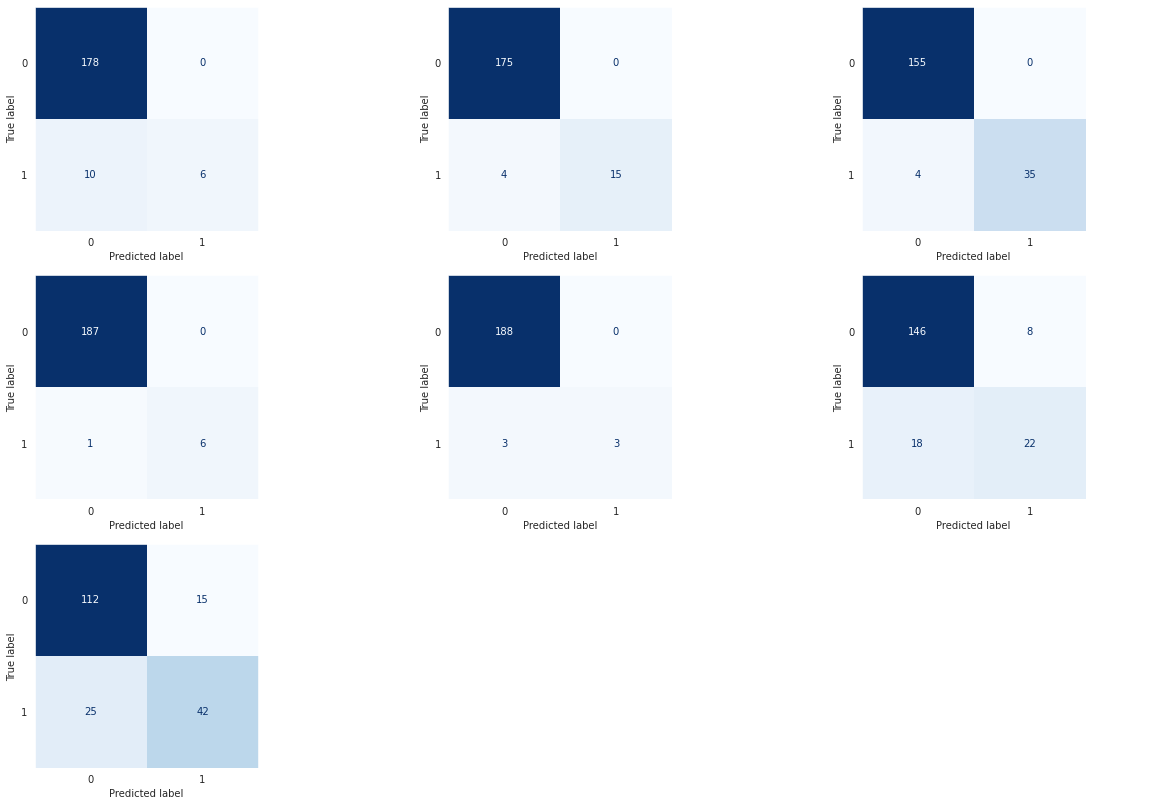

In [15]:
# multilabel_confusion_matrix shows a confusion matrix for every class separately
# based on comparing the model's prediction to the real values
# Be careful not to confuse the true and predicted values!
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrices = sklearn.metrics.multilabel_confusion_matrix(y_true=val[target], y_pred=rf.predict(val[inp]))
fig, ax = plt.subplots(3,3,figsize=(len(target)*3, len(target)*2))
for i in range(len(target)):
    disp = ConfusionMatrixDisplay(conf_matrices[i])
    disp.plot(values_format='d', ax = ax[i//3,i%3], colorbar=False, cmap=plt.cm.Blues)
    ax[i//3,i%3].grid(False)
    print(conf_matrices[i])

ax[2, 1].axis('off')
ax[2, 2].axis('off')

plt.show()




How often a class occurs (also called the __support__ for the class) is important to take into account when interpreting the accuracy scores of a model.

### Example

If a class occurs 1/6th of the time, and the detection was done randomly by rolling a 6 on a dice, this is what would happen:

* $\frac{5}{6}$ of the time, the class would not occur, and $\frac{1}{6}$ of the time, the class would occur.
* Uncorrelated to this, the model would randomly claim to have detected the class $\frac{1}{6}$ of the time, and randomly claim not to detect anything $\frac{5}{6}$ of the time.

This would lead to, e.g. $\frac{5}{6} \times \frac{5}{6} = \frac{25}{36}$ true negatives.

So this is what the confusion matrix would look like in this case:

$$\begin{bmatrix}
\dfrac{25}{36} & \dfrac{5}{36} \\
\dfrac{5}{36} & \dfrac{1}{36} \\
\end{bmatrix}$$

This would lead our dice-roll AI to have an accuracy of $\frac{25}{36} + \frac{1}{36} = \frac{26}{36} \approx 72\%$.

This means that for a model to perform better-than-chance, it would have to reach an accuracy of at least 72%. Even more worrisome, a model which simply detects nothing will have an accuracy of $\frac{5}{6} \approx 83\%$.  With a stronger class imbalance, this becomes extremely important to check.

### Exercise 6

The training set has a size of 1552 and there are 44 instances of the `Dirtiness` class. This gives this class a support of just under 3%.

Write down the confusion matrix for `Dirtiness` for a model that never detects the class at all. (Optional: and for a model that randomly claims a detection with a probability of 3%.) What is the accuracy?



## Classification Report

A classification report shows a few important statistics: precision, recall, f1-score and support. They are defined as followed:

* **Precision**: The percentage of time a detection is correct. TP / (TP + FP)
* **Recall**: The percentage of time a model correctly detects something that it should. TP / (TP + FN)
* **F1-score**: A measurement averaging precision and recall. 2 * (precision * recall) / (precision + recall) = TP / (TP + (FP + FN)/2)
* **Support**: A measure of how often the class occurs in the dataset, how much the dataset "supports" the class. This is independent of the model's functioning, but helps in gauging whether it is a minority or majority class

In [16]:
print(sklearn.metrics.classification_report(y_true=val[target], y_pred=rf.predict(val[inp]), target_names=target))

              precision    recall  f1-score   support

      Pastry       1.00      0.38      0.55        16
   Z_Scratch       1.00      0.79      0.88        19
   K_Scratch       1.00      0.90      0.95        39
      Stains       1.00      0.86      0.92         7
   Dirtiness       1.00      0.50      0.67         6
       Bumps       0.73      0.55      0.63        40
Other_Faults       0.74      0.63      0.68        67

   micro avg       0.85      0.66      0.75       194
   macro avg       0.92      0.66      0.75       194
weighted avg       0.85      0.66      0.74       194
 samples avg       0.66      0.66      0.66       194



//dodrio/scratch/projects/explor_2022_008/miniconda/envs/ai4mi/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looking at the Dirtiness class, we see what we mentioned earlier. The model has a precision of 100%, meaning that if it detects a Dirtiness class, it is always correct. But it only has a recall of 50%, showing that it only detects it half the time. This is why the F1-score is often considered so useful, as it shows an averaging between precision and recall. It's not always useful, as it tends to ignore true negatives, which might be important.

Another useful metric is the **Matthews Correlation Coefficient** or phi coefficient.
It is not a percentage, but it is a correlation measure. A MCC of +1 shows a perfect correlation between the true values and the predicted values, a MCC of -1 shows a perfect anti-correlation, a value of 0 shows the two sets are completely unrelated. The advantage of this coefficient is that it is not sensitive to the support, and is thus a more reliable metric in the case of very large majority classes or very small minority classes.

In [17]:
for i in range(len(target)):
    print(target[i].ljust(15), np.round(sklearn.metrics.matthews_corrcoef(y_true=val[target].values.T[i], y_pred=rf.predict(val[inp]).T[i]), 3))

Pastry          0.596
Z_Scratch       0.879
K_Scratch       0.935
Stains          0.923
Dirtiness       0.702
Bumps           0.557
Other_Faults    0.531


### Exercise 7

Look at the confusion matrix (using `sklearn.metrics.confusion_matrix`) and classification report of the model you trained for `Other_Faults` in Exercise 5. What does this tell you?

In [18]:
from sklearn.metrics import confusion_matrix
?confusion_matrix

Signature:
confusion_matrix(
    y_true,
    y_pred,
    *,
    labels=None,
    sample_weight=None,
    normalize=None,
)
Docstring:
Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` and
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

Read more in the :ref:`User Guide <confusion_matrix>`.

Parameters
----------
y_true : array-like of shape (n_samples,)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,)
    Estimated targets as returned by a classifier.

labels : array-like of shape (n_classes), default=None
    List of labels to index the matrix. This may be used to reorder
    or select a subset of labels.
    If

### Solution

***

# Interpretation of the model

Instead of the model being a black box that you put data in to have it blindly spit out numbers, it can be very useful to consider how it comes to conclusions and what features it uses to make decisions. One such method of investigating is by looking at feature importance. A feature importance is the answer to the question: "If the model became blind to this feature, how would its predictions change?" There are several ways to go about this, including but not limited to:

* **Drop-column feature importance** is fairly straightforward: after deleting the feature, you retrain the model and see how its performance is affected. This can get costly however, if you have a lot of features, and need to retrain for each one. Furthermore, drop-column importance could vastly underestimate the importance of certain information if the dropped column strongly correlates with another feature. That way the model still "sees" the same information, and its performance won't be impacted, leaving you unaware of how much it actually contributes.
* **Permutation importance** completely shuffles one column in the input data and then sees how the model's predictions are affected. This has the benefit of not having to retrain the model, and the data that is given to the model has the same global statistics, yet is completely random. For a simple and fairly robust insight in your model, permutation importance can be useful. However once again, correlations with other features can muddle the picture in non-trivial and unintuitive ways.

## Shapley values

A statistically robust way to consider the way certain features contribute to the performance of the model are Shapley values. They consider the impact each feature has on the predictions, not just in isolation, but also in conjunction with other features. The idea is to consider each feature as an agent in a cooperative game where the goal is to collaborate to make the best prediction. Some players (features) will push the outcome up, others down. Some will reinforce each other, others will work against one another. Shapley values consider the effect of not just losing one feature, but losing every possible combination of features, and then drawing conclusions about single features from that. Sadly, this is almost always prohibitively expensive to calculate exactly. Luckily there is SHAP (SHapley Additive exPlanations), a package that efficiently estimates Shapley values.

In [19]:
import shap

Let us consider the Pastry defect.

In [20]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, max_features=0.5, oob_score=True, random_state=seed)
rf.fit(train[inp], train['Pastry'])
print('Train:',rf.score(train[inp], train['Pastry']))
print('OOB:',rf.oob_score_)
print('Val:',rf.score(val[inp], val['Pastry']))

Train: 0.961340206185567
OOB: 0.9362113402061856
Val: 0.9381443298969072


In [21]:
shap_values = shap.TreeExplainer(rf).shap_values(X=train[inp],approximate=False)[1]
# The [1] is to select the prediction that the fault is detected.

Pastry


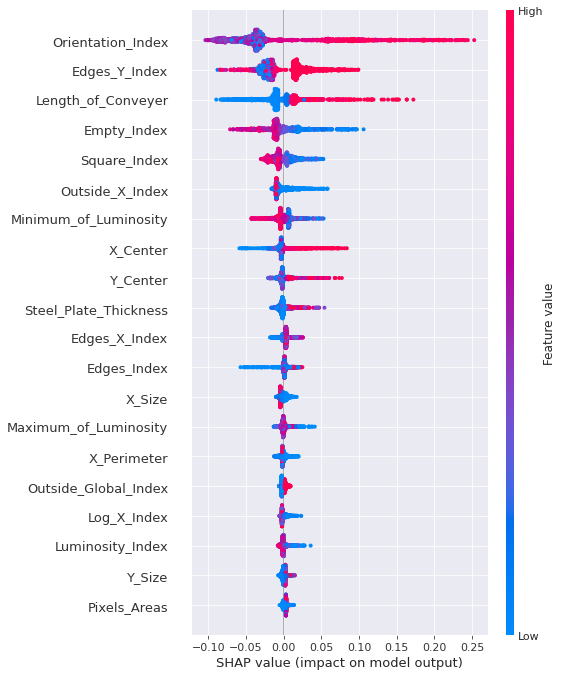

In [22]:
print('Pastry')
shap.summary_plot(shap_values, train[inp],show=False)

It's clear that for the Pastry defect, the Orientation_Index is very important, with a clear distinction between high and low values on either side of the zero value. That means that Pastry defects have a preferred orientation, much more so than the other defects. The length of the conveyer and the X_Center features are also important and clearly divided along high and low values, more clues that the model tends to detect this defect based on position and orientation.

Another helpful way to plot SHAP values is by their absolute value, to see how much each feature contributes.

Pastry


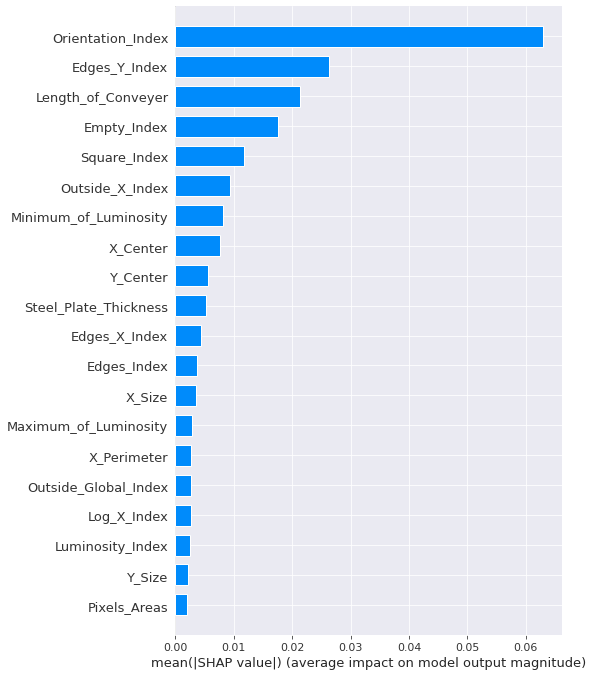

In [23]:
print('Pastry')
shap.summary_plot(shap_values, train[inp], plot_type="bar", show=False)

Clearly the Orientation_Index is the most important feature for this defect. If we wanted, we could use these SHAP values to trim the features that hardly contribute to classifications at all. This way the model becomes easier to (re)train, lighter to use and more transparent to investigate. Be aware however that dropping too many "unimportant" features at once could have a surprising effect on the performance of your model.

In [24]:
trimmed_input = ["Orientation_Index", "Edges_Y_Index", "Length_of_Conveyer",
                 "Empty_Index", "Outside_X_Index", "Minimum_of_Luminosity",
                 "X_Center", "Square_Index", "Y_Center", "Steel_Plate_Thickness"]

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, max_features=0.5, oob_score=True, random_state=seed)
rf.fit(train[trimmed_input], train['Pastry'])
print('Train:',rf.score(train[trimmed_input], train['Pastry']))
print('OOB:',rf.oob_score_)
print('Val:',rf.score(val[trimmed_input], val['Pastry']))

Train: 0.9568298969072165
OOB: 0.9375
Val: 0.9329896907216495


Note that the performance of the model is barely affected, even though we dropped over half the features.

Pastry


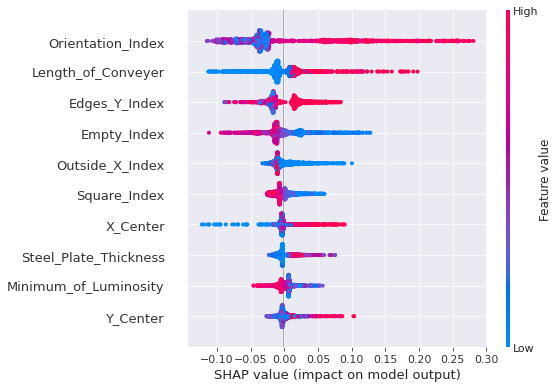

In [25]:
shap_values = shap.TreeExplainer(rf).shap_values(X=train[trimmed_input],approximate=False)[1]
print('Pastry')
shap.summary_plot(shap_values, train[trimmed_input],show=False)

Pastry


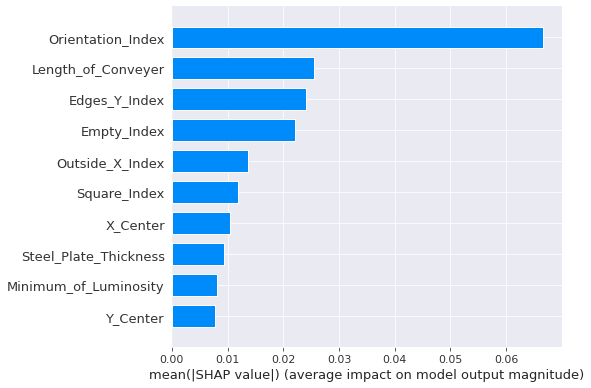

In [26]:
print('Pastry')
shap.summary_plot(shap_values, train[trimmed_input], plot_type="bar", show=False)

### Exercise 8

Use SHAP to inspect the Shapley values of your earlier `Other_Faults` model from Exercises 5 and 7.
* What is it basing its decisions on?
* Can you trim the features?
* How does this affect performance?
* (optional) Optimize the hyperparameters of your new model, do they change and why?
* (optional) If you calculate the permutation importance for the top 5 features, is their order the same?
* (optional) Compare the shapley values with drop-column importance and permutation importance.
* Save your final model using `joblib.dump` for later usage!

### Solution